In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectMultiple
import pyarrow.parquet as pq
from pathlib import Path

meta_path = Path('data/train_meta_batch_1.parquet')
data_path = Path('data/batch_1.parquet')

meta_table = pq.read_table(meta_path)
data_table = pq.read_table(data_path)
meta_df = meta_table.to_pandas()
data_df = data_table.to_pandas()

# Reset the index to make 'event_id' a regular column
data_df.reset_index(inplace=True)

print(meta_df.head())
print("Length of DataFrame:", len(meta_df))
print(data_df.head())
print(f' Keys in data: {data_df.columns.tolist()}')

   batch_id  event_id  first_pulse_index  last_pulse_index   azimuth    zenith
0         1        24                  0                60  5.029555  2.087498
1         1        41                 61               111  0.417742  1.549686
2         1        59                112               147  1.160466  2.401942
3         1        67                148               289  5.845952  0.759054
4         1        72                290               351  0.653719  0.939117
Length of DataFrame: 200000
   event_id  sensor_id  time  charge  auxiliary
0        24       3918  5928   1.325       True
1        24       4157  6115   1.175       True
2        24       3520  6492   0.925       True
3        24       5041  6665   0.225       True
4        24       2948  8054   1.575       True
 Keys in data: ['event_id', 'sensor_id', 'time', 'charge', 'auxiliary']


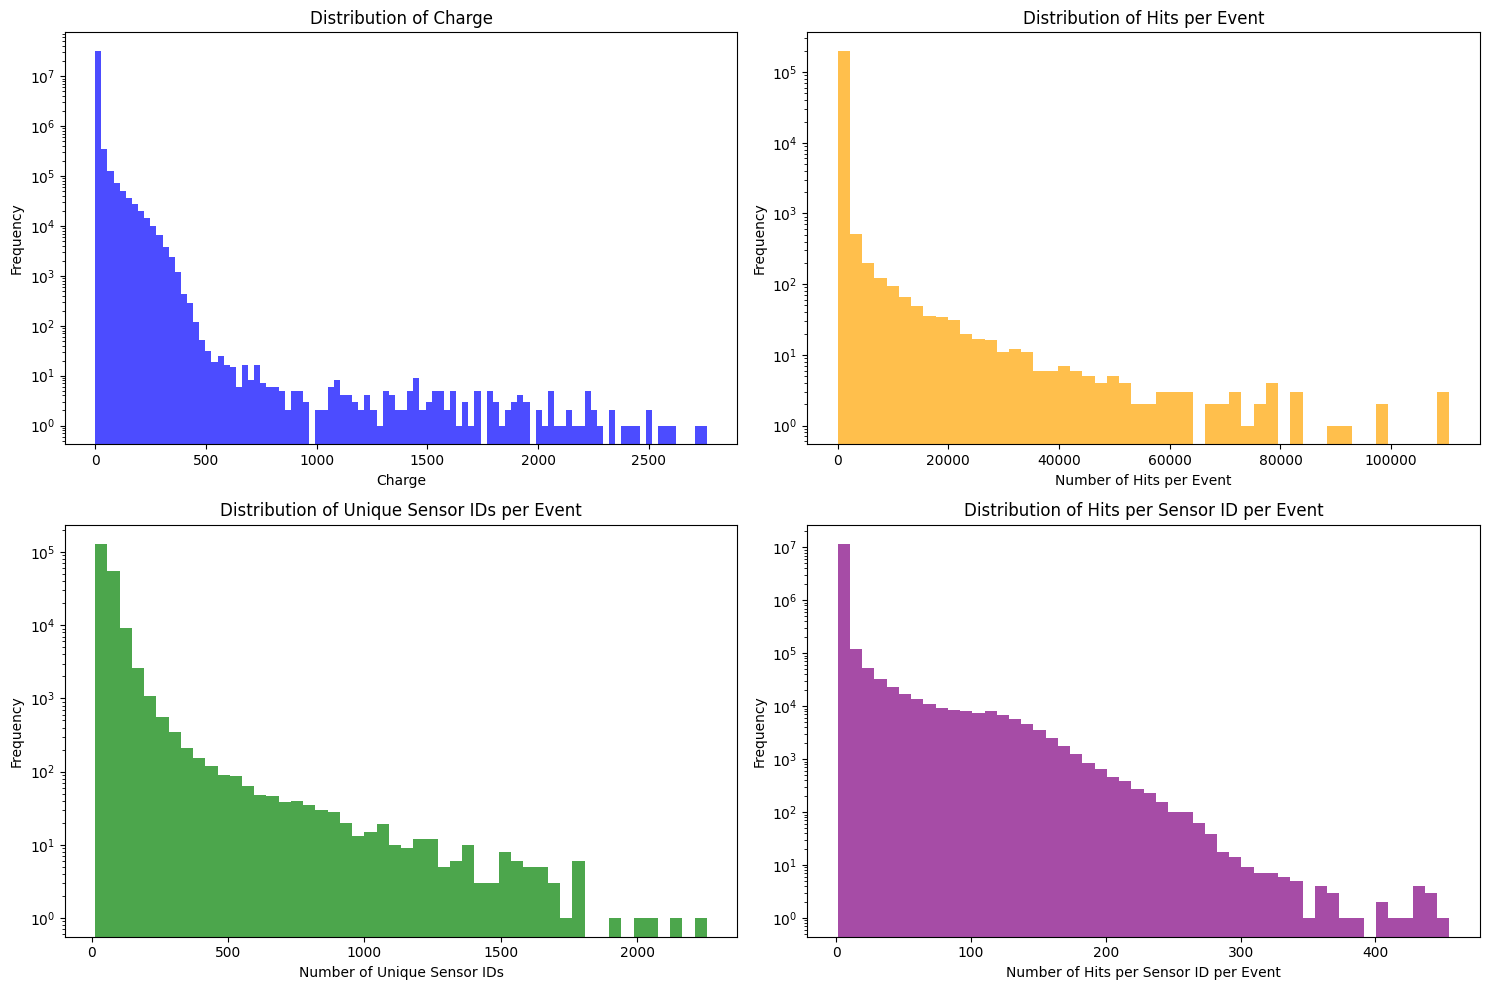

In [2]:
# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Distribution of the charge
axes[0, 0].hist(data_df['charge'], bins=100, color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Charge')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Charge')
axes[0, 0].set_yscale('log')

# Plot 2: Distribution of the number of hits per event
hits_per_event = data_df['event_id'].value_counts().sort_index()
axes[0, 1].hist(hits_per_event, bins=50, color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Number of Hits per Event')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Hits per Event')
axes[0, 1].set_yscale('log')

# Plot 3: Distribution of the number of sensor_ids per event
sensor_counts = data_df.groupby('event_id')['sensor_id'].nunique()
axes[1, 0].hist(sensor_counts, bins=50, color='green', alpha=0.7)
axes[1, 0].set_xlabel('Number of Unique Sensor IDs')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Unique Sensor IDs per Event')
axes[1, 0].set_yscale('log')

# Plot 4: Distribution of the number of hits per sensor_id per event
hits_per_sensor_event = data_df.groupby(['event_id', 'sensor_id']).size()
axes[1, 1].hist(hits_per_sensor_event, bins=50, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Number of Hits per Sensor ID per Event')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Hits per Sensor ID per Event')
axes[1, 1].set_yscale('log')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

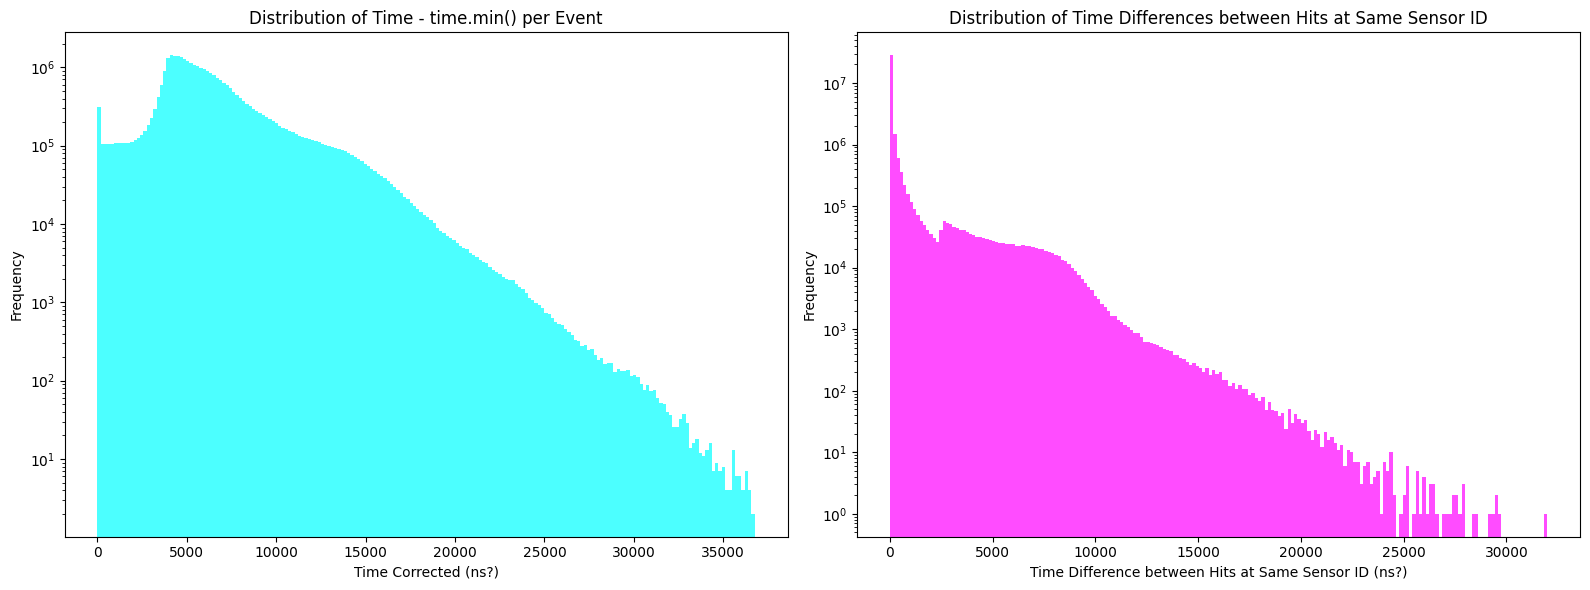

In [3]:
# Create a 1x2 grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution of time - time.min() per event
data_df['time_corrected'] = data_df['time'] - data_df.groupby('event_id')['time'].transform('min')
axes[0].hist(data_df['time_corrected'], bins=200, color='cyan', alpha=0.7)
axes[0].set_xlabel('Time Corrected (ns?)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Time - time.min() per Event')
axes[0].set_yscale('log')

# Plot 2: Distribution of time differences between hits at the same sensor_id per event
data_df = data_df.sort_values(by=['event_id', 'sensor_id', 'time'])
data_df['time_diff'] = data_df.groupby(['event_id', 'sensor_id'])['time'].diff().fillna(0)
axes[1].hist(data_df['time_diff'], bins=200, color='magenta', alpha=0.7)
axes[1].set_xlabel('Time Difference between Hits at Same Sensor ID (ns?)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Time Differences between Hits at Same Sensor ID')
axes[1].set_yscale('log')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [4]:
# Calculate time_corrected for the first 5 events and find the global max
time_corrected_max = 0
time_corrected_list = []
charge_binned_list = []

for i in range(0, 10):
    # Filter data for the current event
    event_data = data_df[data_df['event_id'] == meta_df['event_id'].iloc[i]]
    
    # Calculate time_corrected
    time = event_data['time']
    min_time = time.min()
    time_corrected = time - min_time
    time_corrected_list.append(time_corrected)
    # Update the global max for consistent binning
    time_corrected_max = max(time_corrected_max, time_corrected.max())
    
# Bin the time_corrected values
bins = np.linspace(0, time_corrected_max, 50)

for i in range(0, 10):
    event_data = data_df[data_df['event_id'] == meta_df['event_id'].iloc[i]]
    # Get indices of bins for each time_corrected value
    digitized = np.digitize(time_corrected_list[i], bins)

    charge = event_data['charge']
    # Sum charges where time_corrected_list falls into same bin
    charge_binned = [event_data['charge'][digitized == j].sum() for j in range(1, len(bins))]
    charge_binned_list.append(charge_binned)

# Define bins using the global max of time_corrected
bins = np.linspace(0, time_corrected_max, 50)

# Interactive plot function
def plot_events(selected_events):
    plt.figure(figsize=(10, 6))
    for event_id in selected_events:
        i = meta_df[meta_df['event_id'] == event_id].index[0]
        bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers
        plt.bar(bin_centers, charge_binned_list[i], width=np.diff(bins), alpha=0.5, label=f'Event {event_id}')
    plt.xlabel('Time Corrected')
    plt.ylabel('Charge')
    plt.title('Charge vs Time Corrected for Selected Events')
    plt.legend()
    plt.show()



In [5]:
# Create interactive widget
event_ids = meta_df['event_id'].tolist()
interact(plot_events, selected_events=SelectMultiple(options=event_ids[:10], value=event_ids[:10], description="Event IDs"))

interactive(children=(SelectMultiple(description='Event IDs', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=(2…

<function __main__.plot_events(selected_events)>

In [6]:
# Stacked plot function
def plot_events_stacked(selected_events):
    plt.figure(figsize=(10, 6))
    
    # Initialize an array to hold the cumulative charge for stacking
    cumulative_charge = np.zeros(len(bins) - 1)
    
    for event_id in selected_events:
        i = meta_df[meta_df['event_id'] == event_id].index[0]
        bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers
        plt.bar(bin_centers, charge_binned_list[i], width=np.diff(bins), bottom=cumulative_charge, alpha=0.5, label=f'Event {event_id}')
        cumulative_charge += charge_binned_list[i]  # Update the cumulative charge for stacking
    
    plt.xlabel('Time Corrected')
    plt.ylabel('Charge (Stacked)')
    plt.title('Stacked Charge vs Time Corrected for Selected Events')
    plt.legend()
    plt.show()

# Interactive widget for stacked plot
interact(plot_events_stacked, selected_events=SelectMultiple(options=event_ids[:10], value=event_ids[:10], description="Event IDs"));

interactive(children=(SelectMultiple(description='Event IDs', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=(2…

In [7]:
# Percentage of auxiliary hits that are False
auxiliary_false_percentage = (data_df['auxiliary'] == False).mean() * 100
print(f'Percentage of auxiliary hits that are False: {auxiliary_false_percentage:.2f}%')

Percentage of auxiliary hits that are False: 71.82%
